# 프로젝트 : 폐렴 진단기 성능개선

- 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기
- 하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

In [133]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.6.0


### Step 1. 실험환경 Set-up

In [156]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16 # 16, 32?
EPOCHS = 10 # 15, 10
# (추가 사항)
FILTER_SIZE = 64 # Resnet의 목표 테스크가 다르므로 필터사이즈도 튜닝, 12, 6, 3

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행

의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

> 이전 실습에서 고려하지 않았던 **augmentation 기법**을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
> 그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.
 -  tf.image.random_flip_left_right(image)

In [135]:
# 전처리
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [136]:
# val이 너무 적어서 train에서 나누어줌

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [137]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0678-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [138]:
# 정상과 비정상 갯수 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

## 비정상이 3배정도 많음

Normal images count in training set: 1062
Pneumonia images count in training set: 3123


**tf.data 인스턴스**
 - tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌

In [139]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [140]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없음
 - 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [141]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈 통일 & 축약
- 메모리 효율

> process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [142]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

Process 함수를 이용하여 데이터셋 만듦
- train_list_ds: 위의 tf.data...로 만들어진 인스턴스
- **num_parallel_calls 파라미터** 에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리

In [143]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [144]:
## 한개 꺼내서 사이즈 및 라벨링이 잘된지 체크
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


Test도 똑같이 만듦

In [145]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### tf.data 파이프라인
Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

In [91]:
# # 셔플링
# # 에폭 학습에서 여러번 불러올 수 있게 repeat 정의
# # batch를 통해 배치 사이즈 정의
# # prefetch를 통해 리소스 유휴 상태를 줄일 수 있음
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

#### 데이터 Augmentation

- 전처리에 증강 기법을 추가함
- (추가 사항) 
    - 밝기 조절과 center crop을 적용
        > 이미지가 전체적으로 뿌연 경우에도 구별을 잘해야하므로 강건한 인식을 위해 밝기를 더 높게 주어 노이즈를 추가함
        
        > 육안으로 봤을 때, 폐의 선명도도 cue가 될 수 있으므로 Center crop으로 폐에 더욱 집중하게 함

In [92]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.adjust_brightness(image, 0.1)  # 밝기를 조절
    image = tf.image.central_crop(image, central_fraction=0.8) # 중앙을 중심으로 크롭
    image = tf.image.resize(image, IMAGE_SIZE)
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


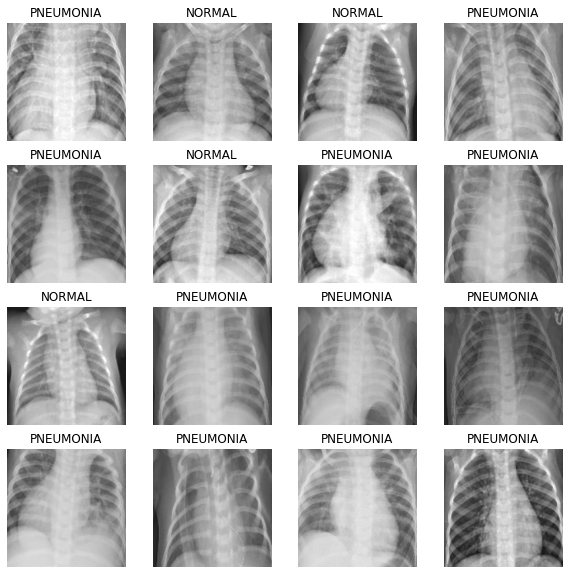

In [93]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현

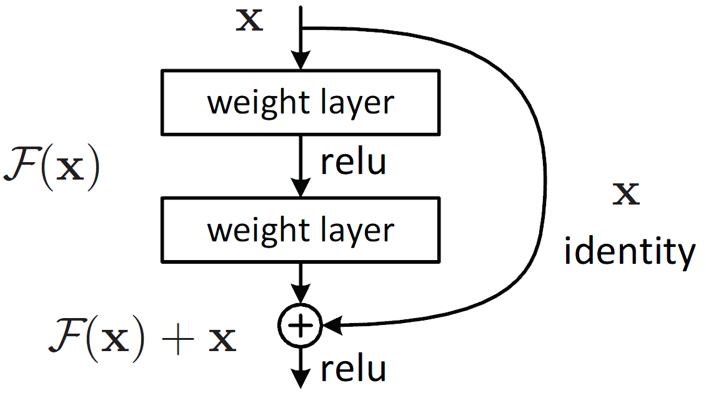

In [94]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block(x, filter_mult, stride=2):
    # 첫 번째 컨볼루션 레이어
    x_shortcut = x
    x = tf.keras.layers.Conv2D(filter_mult, (3, 3), strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # 두 번째 컨볼루션 레이어
    x = tf.keras.layers.Conv2D(filter_mult,(3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # short cut에도 layer를 추가하는 경우
    x_shortcut = tf.keras.layers.Conv2D(filter_mult,(3, 3), strides=2, padding='same')(x_shortcut)
    
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    return x

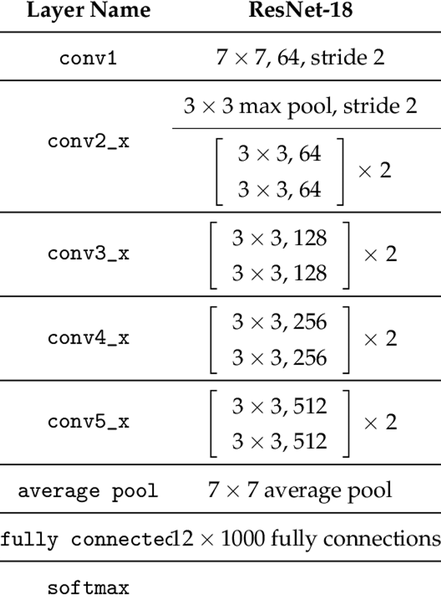

In [152]:
def resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial Convolution Layer
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    num_blocks = [2, 2, 2, 2]  # ResNet-18 has 2 blocks in each of the 4 stages

    for stage in range(4):
        filter_mult = FILTER_SIZE #init
        for block in range(num_blocks[stage]):
            x = residual_block(x, filter_mult*2)

    # GlobalAverage Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, x)

    return model

model = resnet18()
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_521 (Conv2D)             (None, 90, 90, 64)   9472        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_361 (BatchN (None, 90, 90, 64)   256         conv2d_521[0][0]                 
__________________________________________________________________________________________________
re_lu_354 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_361[0][0]    
___________________________________________________________________________________________

### Step 5. imbalance 처리

- 우선은 class weight를 빼고 실험

### Step 6. 모델 훈련
- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [149]:
# gpu를 이용해서 훈련 정의
with tf.device('/GPU:0'):
    model = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop', # 'rmsprop', 
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [101]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/15
261/261 [==============================] - 107s 196ms/step - loss: 0.2950 - accuracy: 0.7380 - precision: 0.7380 - recall: 1.0000 - val_loss: 0.1983 - val_accuracy: 0.7606 - val_precision: 0.7606 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 51s 194ms/step - loss: 0.1907 - accuracy: 0.7385 - precision: 0.7385 - recall: 1.0000 - val_loss: 4.1404 - val_accuracy: 0.7587 - val_precision: 0.7587 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 50s 194ms/step - loss: 0.1441 - accuracy: 0.7366 - precision: 0.7366 - recall: 1.0000 - val_loss: 0.2440 - val_accuracy: 0.7587 - val_precision: 0.7587 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 51s 195ms/step - loss: 0.1441 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.3318 - val_accuracy: 0.7587 - val_precision: 0.7587 - val_recall: 1.0000
Epoch 5/15
261/261 [==============================] - 52s 198ms/step - loss: 0.1170 - accur

### Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.



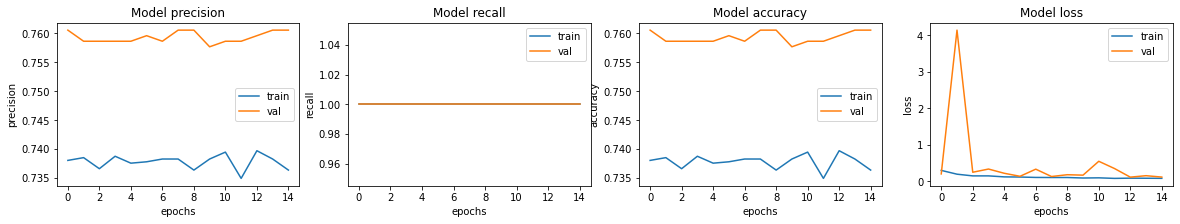

In [102]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 8. 테스트 체크

In [114]:
results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc, pre, recall:", results)

39/39 [==============================] - 4s 104ms/step - loss: 1.0691 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
test loss, test acc, pre, recall: [1.0691006183624268, 0.625, 0.625, 1.0]


In [111]:
y_pred = model.predict(test_ds,batch_size=BATCH_SIZE)

<AxesSubplot:ylabel='count'>

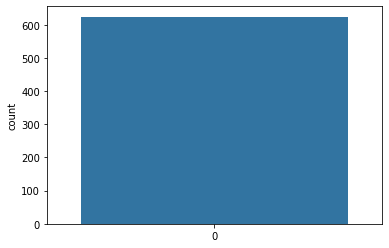

In [121]:
# 모든 값을 1로 예측하고 있음을 확인
import seaborn as sns
sns.countplot(data=y_pred)

## 재실험 - 실험 변수 변경 트레이닝
- augment 변경
- 하이퍼파라미터 튜닝 (필터사이즈 변경)
- 옵티마이저 변경 ('adam')

In [146]:
def augment_mod_ver1(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.adjust_brightness(image, 0.2)  # 밝기를 조절
    image = tf.image.central_crop(image, central_fraction=0.7) # 중앙을 중심으로 크롭
    image = tf.image.resize(image, IMAGE_SIZE)
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


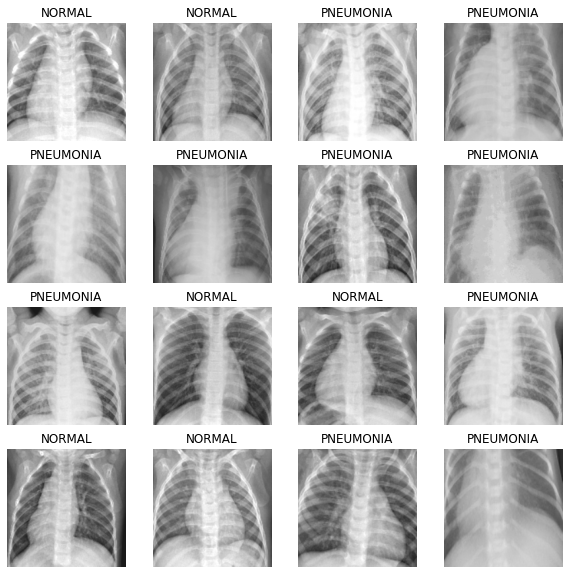

In [147]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [153]:
# gpu를 이용해서 훈련
#BATCH_SIZE = 16 # 16, 32?
#EPOCHS = 15 #10
# (추가 사항)
#FILTER_SIZE = 3 # Resnet의 목표 테스크가 다르므로 필터사이즈도 튜닝, 12, 6, 3
with tf.device('/GPU:0'):
    model = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer= 'adam', # 'rmsprop','adam'
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/15
261/261 [==============================] - 61s 196ms/step - loss: 0.5476 - accuracy: 0.7459 - precision: 0.7459 - recall: 1.0000 - val_loss: 0.5498 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 50s 194ms/step - loss: 0.3583 - accuracy: 0.7464 - precision: 0.7464 - recall: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 51s 195ms/step - loss: 0.2737 - accuracy: 0.7462 - precision: 0.7462 - recall: 1.0000 - val_loss: 0.2349 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 51s 197ms/step - loss: 0.2301 - accuracy: 0.7457 - precision: 0.7457 - recall: 1.0000 - val_loss: 0.2234 - val_accuracy: 0.7240 - val_precision: 0.7240 - val_recall: 1.0000
Epoch 5/15
261/261 [==============================] - 52s 199ms/step - loss: 0.2049 - accura

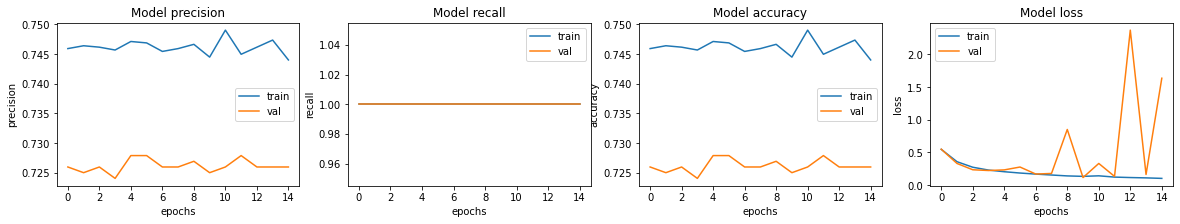

In [155]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**정리 및 회고**

 - 이전 실험에 비해 정확도는 떨어졌음 (약 83% -> 약 73%)
    
 - 그러나 recall은 1로 상승 but, 확인해보니 모든 값을 1로 예측함
    
    < 결과 분석 >
    
> 재실험으로 실험변수를 변경해도 문제가 해결되지 않는 것으로보아 밝기를 높이거나 Center crop 등의 증강 기법 또는 옵티마이저의 영향이 커보이진 않음 

> 수렴이 안되는 것으로 보아 learning rate 스케줄링이 필요해보임
        
> Resnet18 모델의 파라미터를 줄여도 성능이 70%인 것으로 보아 극적인 성능 향상을 위해서는 모델 구조의 변경이나 다른 튜닝이 필요해보임
        
    < 개선 방안 > 
> 적합 문제: loss 그래프가 안정적이지 않는 것으로 보아 learning rate가 적용되어야함 

> 증강 방법론: 양성도 잘 판단하는 precision을 높이기 위해 중앙의 장기(심장)가 뚜렷하게 표현된 상태라면 좀 더 뚜렷하게 보일 수 있도록 선명도를 높일 수도 있을 듯함

> 업샘플링: 데이터의 크기 자체를 키우는 것도 방법이 될 듯 함
        
> 모델 구조 적합: 모델 사이즈 변경 필요

# 재실험 - Learning rate 추가

**문제 발견** 
- 출력이 sigmoid가 아닌 softmax로 계산됨
- 고쳐서 다시 학습

BATCH_SIZE = 16 

EPOCHS = 10 

FILTER_SIZE = 64 

In [160]:
def resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial Convolution Layer
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual Blocks
    num_blocks = [2, 2, 2, 2]  # ResNet-18 has 2 blocks in each of the 4 stages

    for stage in range(4):
        filter_mult = FILTER_SIZE #init
        for block in range(num_blocks[stage]):
            x = residual_block(x, filter_mult*2)

    # GlobalAverage Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs, x)

    return model

model = resnet18()
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_596 (Conv2D)             (None, 90, 90, 64)   9472        input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_412 (BatchN (None, 90, 90, 64)   256         conv2d_596[0][0]                 
__________________________________________________________________________________________________
re_lu_405 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_412[0][0]    
___________________________________________________________________________________________

In [161]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

with tf.device('/GPU:0'):
    model = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer= optimizer, # 'rmsprop','adam'
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/10
261/261 [==============================] - 61s 197ms/step - loss: 0.7192 - accuracy: 0.8410 - precision: 0.8909 - recall: 0.8967 - val_loss: 0.3804 - val_accuracy: 0.9019 - val_precision: 0.9223 - val_recall: 0.9443
Epoch 2/10
261/261 [==============================] - 51s 194ms/step - loss: 0.2323 - accuracy: 0.9104 - precision: 0.9397 - recall: 0.9403 - val_loss: 0.2119 - val_accuracy: 0.8981 - val_precision: 0.9880 - val_recall: 0.8702
Epoch 3/10
261/261 [==============================] - 51s 196ms/step - loss: 0.1900 - accuracy: 0.9253 - precision: 0.9485 - recall: 0.9515 - val_loss: 0.3193 - val_accuracy: 0.8663 - val_precision: 0.9889 - val_recall: 0.8247
Epoch 4/10
261/261 [==============================] - 51s 196ms/step - loss: 0.1816 - accuracy: 0.9363 - precision: 0.9541 - recall: 0.9609 - val_loss: 0.1201 - val_accuracy: 0.9663 - val_precision: 0.9713 - val_recall: 0.9828
Epoch 5/10
261/261 [==============================] - 51s 195ms/step - loss: 0.1279 - accura

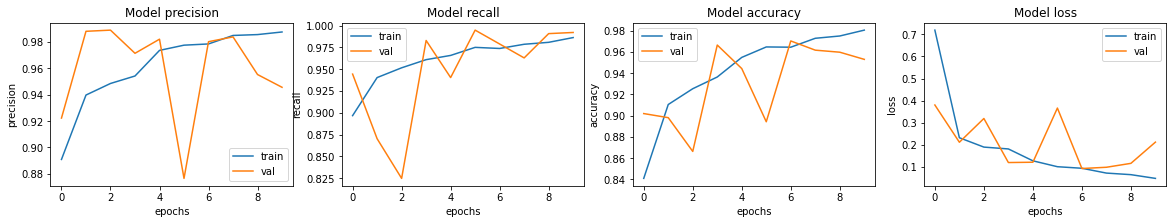

In [162]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 테스트 점수 확인

In [163]:
results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
print("test loss, test acc, pre, recall:", results)

39/39 [==============================] - 5s 117ms/step - loss: 0.8564 - accuracy: 0.8269 - precision: 0.7937 - recall: 0.9769
test loss, test acc, pre, recall: [0.856408953666687, 0.8269230723381042, 0.793749988079071, 0.9769230484962463]


# 재회고

- validation의 acc -> 95%
    - 결과적으로 precision과 recall 모두 좋은 결과를 얻었음

- **test** 의 acc -> 82%,
    - precision: 0.7937 
    - **recall: 0.9769**
    - recall이 97%로 폐렴 진단을 매우 잘하는 것으로 추측할 수 있음
    
- softmax로 출력하던 것을 sigmoid로 바꾸니 학습 상태가 완전히 달랐다.
    - 엄청난 삽질을 했음, 앞으로 에폭 그래프가 수상하면 모델의 출력을 살펴보자 
    - 소프트맥스로 다중 분류가 아닌 이진 분류를 하면 문제가 생길 수 있음을 알았다.